# Topography Runs #

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import sys
from scipy.interpolate import interp1d
from scipy import interpolate
from numba import autojit
from pylab import *
from matplotlib import gridspec
import netCDF4
import cmocean
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
sys.path.append('/noc/users/hb1g13/Python/python_functions/')
from useful import *
from Flat_channel import *
from HB_Plot import nf, fmt
import SG as SG
import layers_calc
import APE_Calc as AC
sys.path.append('/noc/users/hb1g13/Python/python_functions/MITgcmUtils/')
import utils
%matplotlib inline

## Topography added ##

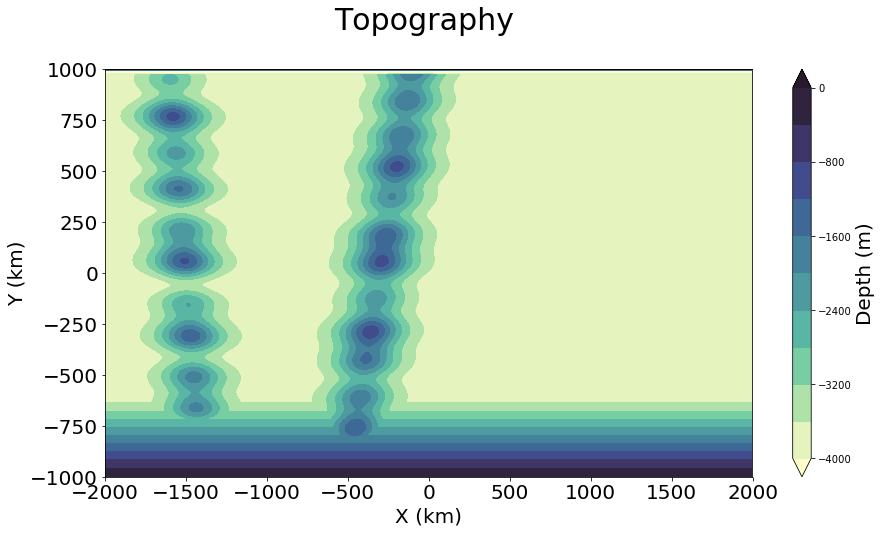

In [6]:
# Basic Parameters 
Res = 5000
Ly = 2000e3
Lx = 4000e3 
H = 4000 
nz = 40 
nx = np.int(Lx/Res)
ny = np.int(Ly/Res)
dx = np.ones(nx)*Res
dy = np.ones(ny)*Res
x = (np.cumsum(dx)-dx/2)-Lx/2
y = (np.cumsum(dy)-dy/2)-Ly/2
# Grid
[Y, X] = np.meshgrid(y,x)
# Bottom of channel
h = -H*np.ones((nx,ny)) # Flat bottom
# Add ridges
Ly2 = 1900e3 # Cut off ridges in sponge
h[:,0:-5] = h[:,0:-5]+(2200 + 300*np.sin(10*pi*Y[:,0:-5]/Ly2)
          + 400*np.sin(8*pi*Y[:,0:-5]/Ly2)
          + 300*sin(25*pi*Y[:,0:-5]/Ly) )*(1/np.cosh(((X[:,0:-5])-0.2*Y[:,0:-5]+3e5)/1.2e5))
h[:,0:-5] = h[:,0:-5]+((1700 + 600*np.sin(11*pi*Y[:,0:-5]/Ly2)
           + 300*np.sin(7*pi*Y[:,0:-5]/Ly2)
           + 500*sin(21*pi*Y[:,0:-5]/Ly2) )
                             *(1/np.cosh(((X[:,0:-5])+0.1*Y[:,0:-5]+1.5e6)/1.2e5)))
# Add slope in
for i in range(int(nx)):
    slope = np.transpose(H*(np.divide((Y[i,0:np.int(0.2*ny)]-Y[i,0]),(Y[i,0]-Y[i,np.int(0.2*ny)]))))
    h2 = h[:,0:np.int(0.2*ny)]
    h[:,0:np.int(0.2*ny)]=np.maximum(slope,h2)
# Close both ends
h[:,0] = 0
h[:,-1] = 0
# Plot figure
plt.figure(figsize = (14.5, 7.5))
plt.contourf(x/1000,y/1000,np.transpose(h),12,extend='both',cmap=cmocean.cm.deep)
cb=plt.colorbar()
ylim(-1000,1000)
plt.title('Topography \n  ', fontsize=30)
plt.ylabel('Y (km)', fontsize=20)
plt.xlabel('X (km)', fontsize=20)
cb.set_label('Depth (m)',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

## The instantaneous fields ##

In [8]:
# Some parameters
Full = 'Extremes'  # 9 Pannels isn't ideal for presentations N option give 4 plots
Qplot = 'Y'
Figletter = ['a) ','b) ','c) ','d) ','e)','f)','g)','h)','j)']
# Path root
x = '/noc/msm/scratch/students/hb1g13/Mobilis/instantaneous'
# Now Make file structure
tau = ['3day_full', 'Closedday_full', '3day', 'Closedday']
check = 0
runs = []
for i in range(len(tau)):
    flist = x+'/'+str(tau[i])+'/Tav.nc'
    if not os.path.exists(flist):
        print ' WARNING: '+flist+' does not exist! (skipping this tau...)'
        check += 0
    else:
        check += 1
        runs.append(i)
Runs=np.array(runs)

/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in greater


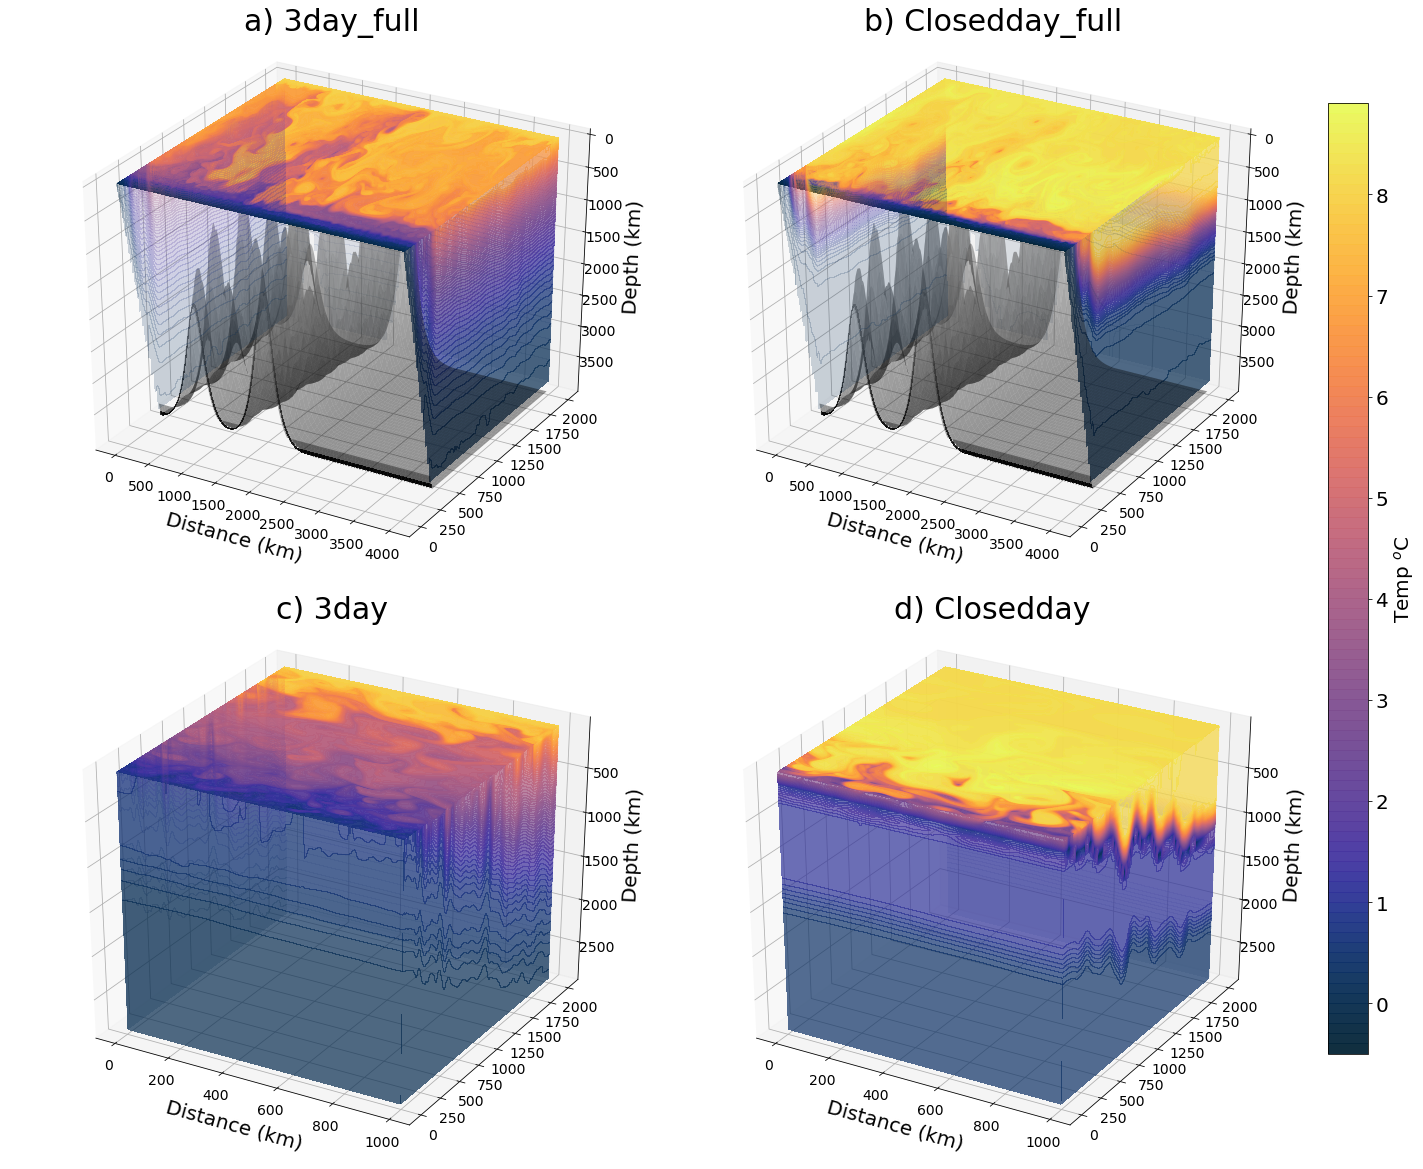

In [9]:
plt.clf
fig = plt.figure(figsize=(18.5, 16.5))
Q2_levs = (np.arange(-.5, 9, .2))
Qticks =(np.arange(-0, 9, 1))
for i in range(len(Runs)):

    fname = x+'/'+str(tau[Runs[i]])+'/'
    c = utils.ChannelSetup(output_dir=str(fname))
    ax = fig.add_subplot(2, 2, i+1,projection='3d')
    Q2_levs = (np.arange(-.5, 9, .1))
    
    X = c.xc/1000
    Y = c.yc/1000
    Z = c.zc
    Xz, Yz = np.meshgrid(X, Y)
    Xx, Zx = np.meshgrid(X, Z)
    Yx, Zy = np.meshgrid(Y, Z)
    
    varone=c.mnc_t('Tav.nc','THETA')
    if varone.shape==4:
        varone=varone[0,:,:,:]
    varone[c.HFacC==0]=np.nan
    if i==3:
        varone[varone>2]= varone[varone>2]-2
    
    Z=varone[:,:,:]
    cset = [[],[],[],[]]
    if i>=2:
        cset = [[],[],[],[],[]]
    # Evaluate an existing colormap from 0.5 (midpoint) to 1 (upper end)
    cmap = plt.get_cmap('Greys')
    colors = cmap(np.linspace(0.5, 1, cmap.N // 2))

    # Create a new colormap from those colors
    cmap2 = LinearSegmentedColormap.from_list('Upper Half', colors)
    
    # zface
    cset[0] = ax.contourf(Xz, Yz, Z[0,:,:], zdir='z', offset=0,
                          levels=Q2_levs,cmap=cmocean.cm.thermal,alpha=.95,extend3d='both')
    if i==0:
        csetall = cset[0]
    if i<3:
        # now, for the x-constant face, assign the contour to the x-plot-variable:
        cset[1] = ax.contourf(Z[:,:,0], Yx, -Zy, zdir='x', offset=0,linewidth=0,
                              levels=Q2_levs,cmap=cmocean.cm.thermal,alpha=0.2,rstride=1, cstride=1)
    # now, for the x-constant face, assign the contour to the x-plot-variable:
    cset[2] = ax.contourf(Z[:,:,-1], Yx, -Zy, zdir='x', offset=(c.xc/1000)[-1],
                          levels=Q2_levs,cmap=cmocean.cm.thermal,alpha=0.7,rstride=1, cstride=1)
    
    # now, for the y-constant face, assign the contour to the y-plot-variable:
    cset[3] = ax.contourf(Xx, Z[:,-2,:], -Zx, zdir='y', offset=(c.yc/1000)[-1],
                          levels=Q2_levs,cmap=cmocean.cm.thermal,alpha=0.1,rstride=1, cstride=1)
    if i<2:
        
        # Topography
        Topo = ax.plot_surface(Xz[75:-5,:].T, Yz[75:-5,:].T, c.Depth[75:-5,:].T, rstride=8, cstride=8, cmap=cmap2,
                           linewidth=0, antialiased=True, alpha=0.4)
        Topo2 = ax.plot_surface(Xz[78:80,:].T, Yz[78:80,:].T, c.Depth[78:80,:].T, rstride=4, cstride=4, cmap=cmap2,
                           linewidth=2, antialiased=False, alpha=0.8)
    if i>=2:
        cset[4] = ax.contourf(Xx, Z[:,1,:], -Zx, zdir='y', offset=1,
                          levels=Q2_levs,cmap=cmocean.cm.thermal,alpha=0.7,rstride=1, cstride=1)
    
    ax.invert_zaxis()
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'\n', fontsize=30)
    ax.set_xlabel('\n Distance (km)', fontsize=20)
    ax.set_zlabel('\n Depth (km)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(csetall, cax=cax, ticks=Qticks)
cbar.ax.set_ylabel('Temp $^o$C', fontsize=20)
cbar.ax.tick_params(labelsize=20)


## Overturning ##

a) 2.27 Sv
b) 16.83 Sv
c) 2.39 Sv
d) 19.34 Sv


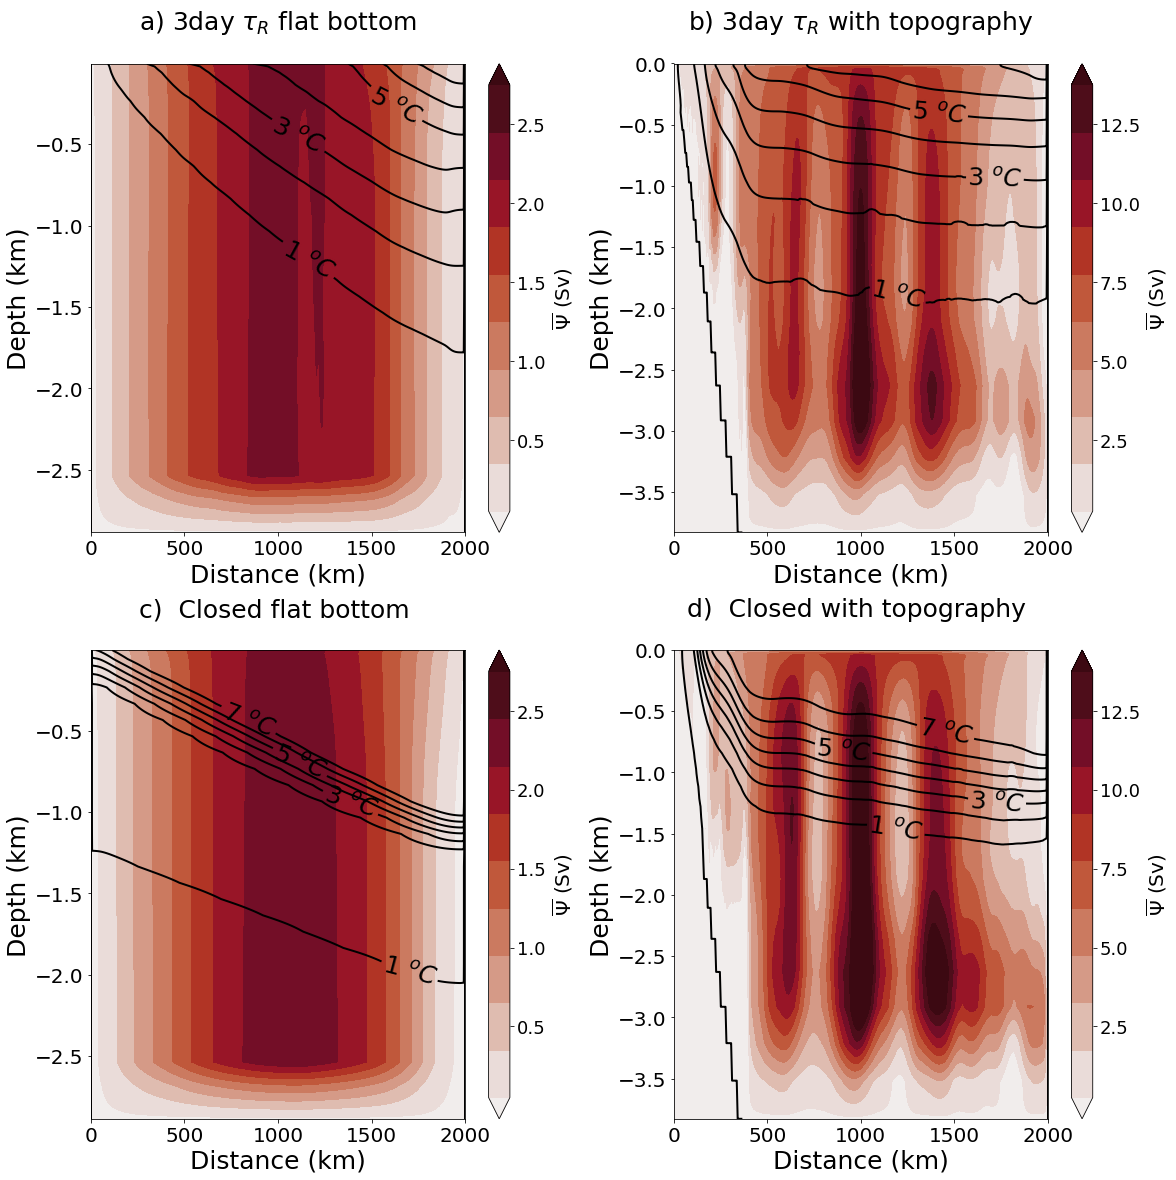

In [16]:
# Path root
x = '/noc/msm/scratch/students/hb1g13/Mobilis'
# Now Make file structure
tau = ['/3daynokpp/', '/Full/3/', '/Closeddaynokpp/', '/Full/Closed/']
Runs=np.array(tau)
Figletter = ['a) ','b) ','c) ','d) ','e)','f)','g)','h)','j)']
fig = plt.figure(figsize=(16.5, 16.5))

Psi_levs = np.arange(0.05, 2.8, .3)
Psi_ticks =np.arange(0, 3., .5)
Q_levs = np.arange(-0., 8., 1)
for i in range(len(Runs)):

    fname = x+str(Runs[i])
    ax = fig.add_subplot(2, 2, i+1)
    c = utils.ChannelSetup(output_dir=str(fname)) 
    V = c.mnc('Tav.nc', 'VVEL')
    V[c.HFacS==0]=0
    vflux = V 
    Vdx = vflux* 5000*np.tile(c.dzf,(c.Nx,c.Ny+1,1)).T*c.HFacS
    Vdx = np.nansum(Vdx, axis=2)
    psi = np.cumsum(Vdx, axis=0)
    npad = ((0, 1), (0, 0),)
    psi = np.pad(psi, pad_width=npad, mode='constant', constant_values=0)
    psi = 0.5*(psi[1:] + psi[:-1])/10**6
    psi[-1] = 0
    Tavlat = c.mnc('Tav.nc','THETA',mask=c.HFacC).mean(axis=2)
    y = c.yc/1000
    yp = c.yg/1000
    if i==1 or i==3:
        scale=5
    else:
        scale=1
    p = ax.contourf(yp, c.zc/1000, psi, Psi_levs*scale,
                    cmap=cmocean.cm.amp,extend='both')
    print Figletter[i]+str(round(psi.max(),2))+' Sv'
    Q2_levs = (np.arange(-1, 8, 1))
    Tavlat = c.get_zonal_avg('Tav.nc','THETA')
    q = ax.contour(y, c.zc/1000,
                   Tavlat, Q2_levs, colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=20)
    
    cbar = fig.colorbar(p, ax=ax,ticks=Psi_ticks*scale)
    cbar.ax.tick_params(labelsize=18)
    cbar.ax.set_ylabel(r'$\overline{\Psi }  $ (Sv)', fontsize=20, )
    if str(Figletter[i])=='a) ':
        ax.set_title(str(Figletter[i])+r'3day $ \tau _{R} $ flat bottom' +'\n', fontsize=25)
    elif str(Figletter[i])=='b) ':
        ax.set_title(str(Figletter[i])+r'3day $ \tau _R $ with topography' +' \n', fontsize=25)
    elif str(Figletter[i])=='c) ':
        ax.set_title(str(Figletter[i])+r' Closed flat bottom ' +'\n', fontsize=25)
    elif str(Figletter[i])=='d) ':
        ax.set_title(str(Figletter[i])+r' Closed with topography ' +'\n', fontsize=25)
        

    ax.set_xlabel('Distance (km)', fontsize=25)
    ax.set_ylabel('Depth (km)', fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()

The Eulerian MOC with topography is around 6 times larger (15 Sv) than the flat bottom runs (2.25 Sv). This lobed overturning structure is likely to be attributed to reynold's stresses. This explains the strength of the MOC in the topography runs as the channel is 4 times longer and the the reynold's stresses sharpen the overturning areas leading to a 6 times larger overturning strength.

a) min = -0.39 Sv, max = 0.77 Sv
b) min = -3.63 Sv, max = 1.74 Sv
c) min = -0.03 Sv, max = 0.1 Sv
d) min = -3.69 Sv, max = 7.33 Sv


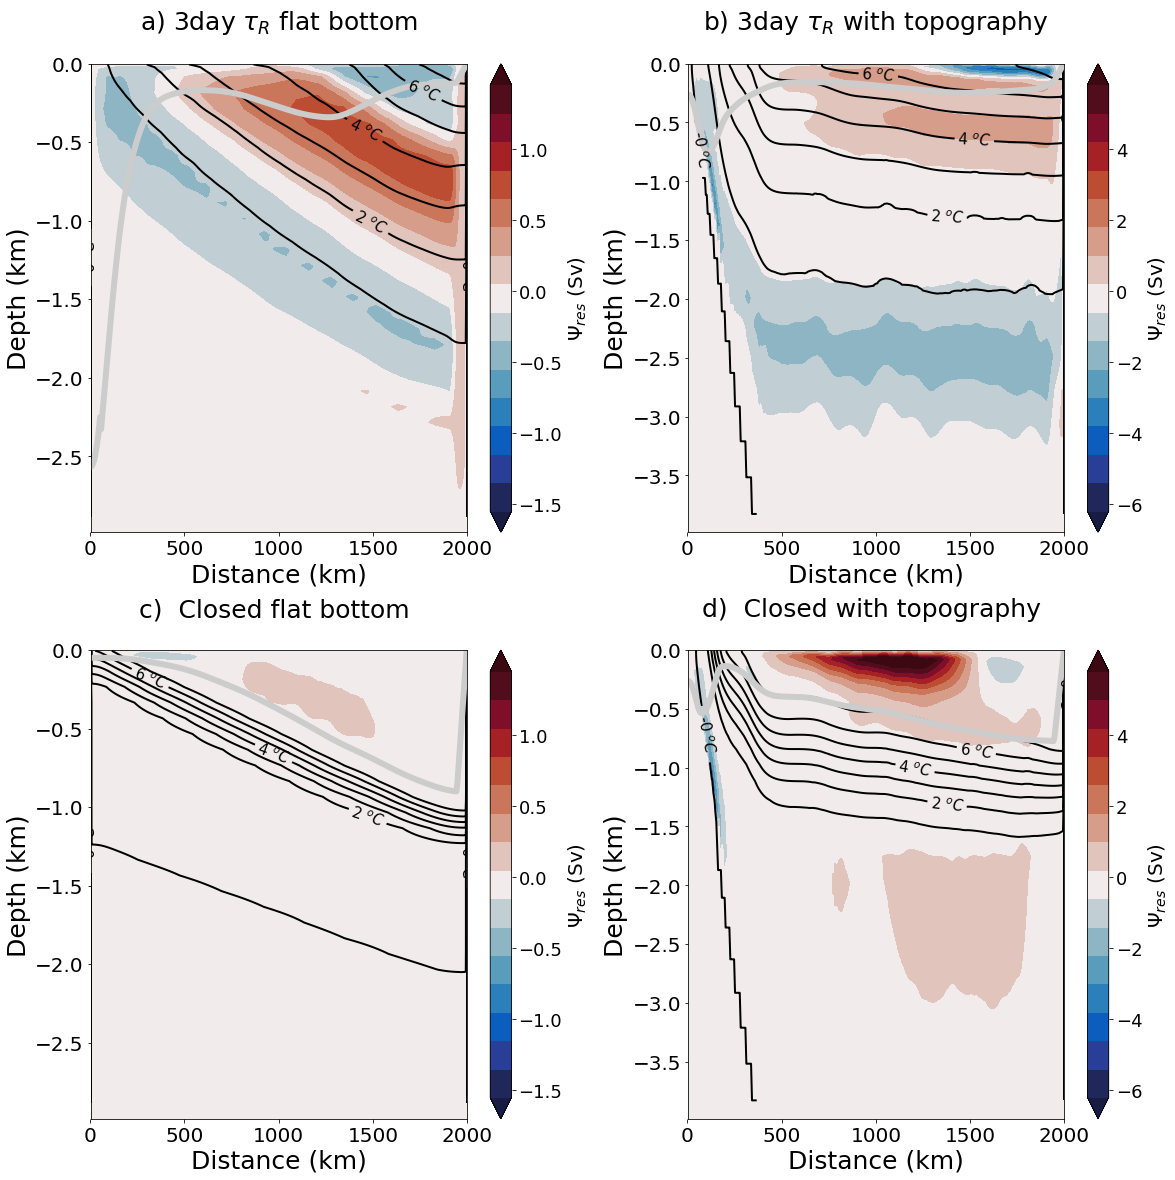

In [20]:
fig = plt.figure(figsize=(16.5, 16.5))
Psi_levs = np.arange(-1.6, 1.6, .2)+0.05
Psi_ticks =np.arange(-2., 2., .5)
Q_levs = np.arange(-0., 8., 1)
for i in range(len(Runs)):
    fname = x+str(Runs[i])
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    Psi = c.get_psi_iso_z()/10**6
    npad = ((0, 1), (0, 0))
    Psi = np.pad(Psi, pad_width=npad, mode='constant', constant_values=0)
    scale= 1
    if i==1 or i==3:
        scale=4
    ax = fig.add_subplot(2, 2, i+1)
    p = ax.contourf(c.yc/1000, c.zf/1000,
                Psi, Psi_levs*scale, cmap=cmocean.cm.balance, extend='both')
    q = ax.contour(c.yc/1000, c.zc/1000, c.get_zonal_avg('Tav.nc','THETA'), Q_levs, colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=15)
    mld = c.mnc('MLD.nc','MXLDEPTH')[0,:,:]
    # Plot mixed layer depth via layer probability
    g = layers_calc.LayersComputer(c)
    PI = c.mnc('PSI.nc', "LaPs1TH").mean(axis=2)
    th = c.mnc('PSI.nc', "LaHs1TH").mean(axis=2)
    PIz = g.transform_g_to_z(PI, th)
    # Remove some nonsense
    PIz[-5::, 50::] = np.nan
    mld = c.mnc('MLD.nc','MXLDEPTH')[0,:,:].mean(axis=1)
    R = ax.plot(c.yc/1000, SG.savitzky_golay(-mld/1000, 21, 1), scalex=False,
                scaley=False, color='0.8', linestyle='-', linewidth=6)
    cbar = fig.colorbar(p, ax=ax,ticks=Psi_ticks*scale)
    cbar.ax.tick_params(labelsize=18)
    cbar.ax.set_ylabel(r'$\Psi  _{res} $ (Sv)', fontsize=20, )
    if str(Figletter[i])=='a) ':
        ax.set_title(str(Figletter[i])+r'3day $ \tau _{R} $ flat bottom' +'\n', fontsize=25)
    elif str(Figletter[i])=='b) ':
        ax.set_title(str(Figletter[i])+r'3day $ \tau _R $ with topography' +' \n', fontsize=25)
    elif str(Figletter[i])=='c) ':
        ax.set_title(str(Figletter[i])+r' Closed flat bottom ' +'\n', fontsize=25)
    elif str(Figletter[i])=='d) ':
        ax.set_title(str(Figletter[i])+r' Closed with topography ' +'\n', fontsize=25)
        
    print Figletter[i]+'min = '+str(round(np.min(Psi[c.zf<-1000]),2))+' Sv'+', max = '+str(round(np.max(Psi),2))+' Sv'
    ax.set_xlabel('Distance (km)', fontsize=25)
    ax.set_ylabel('Depth (km)', fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()


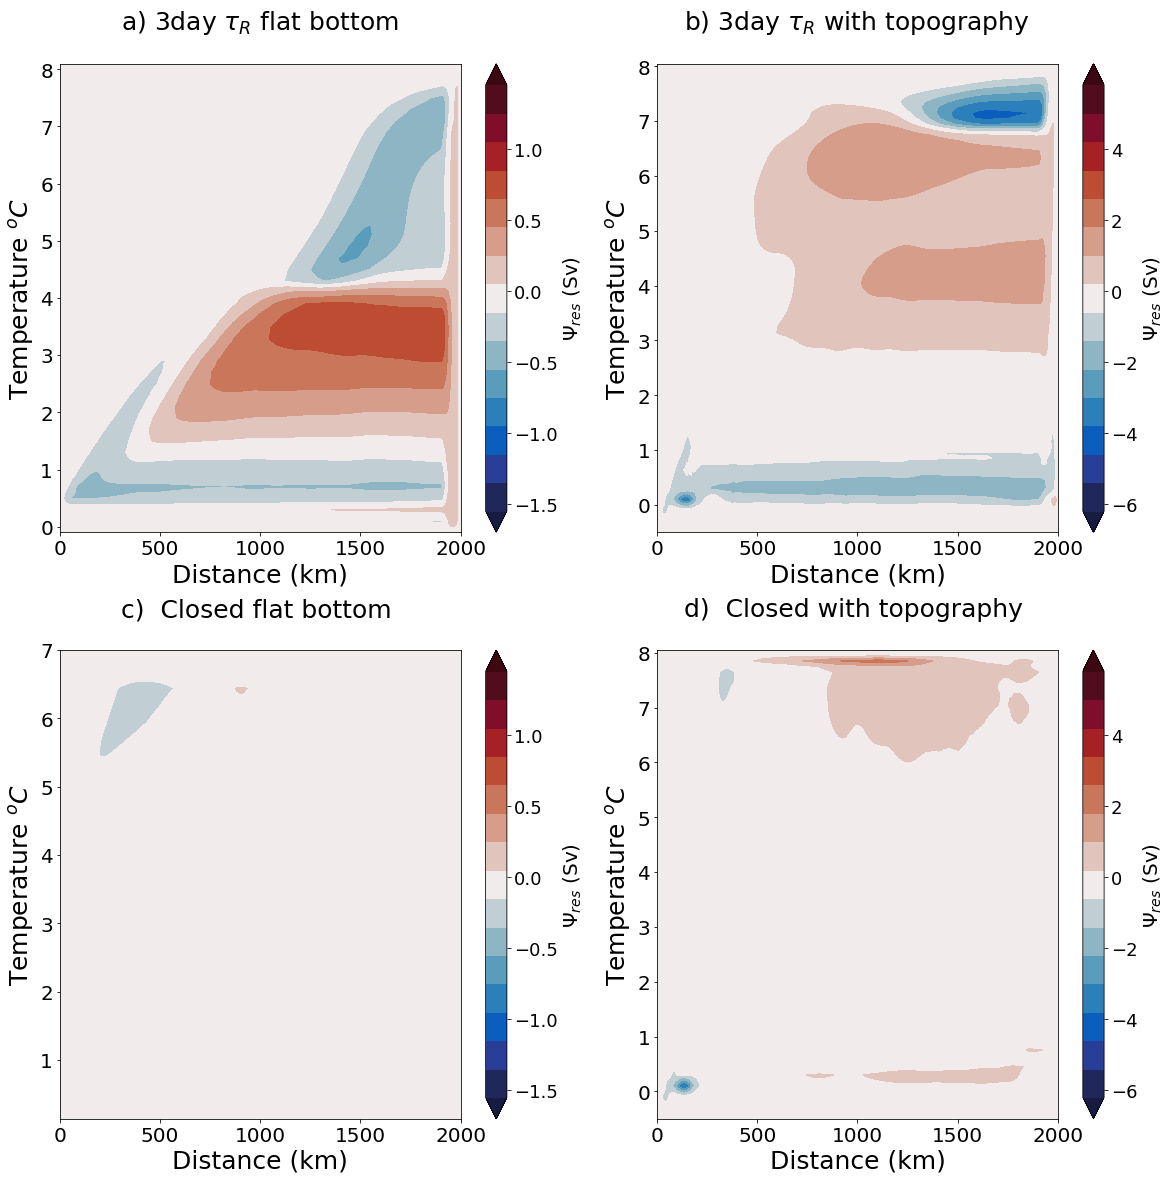

In [21]:
fig = plt.figure(figsize=(16.5, 16.5))
Psi_levs = np.arange(-1.6, 1.6, .2)+0.05
Psi_ticks =np.arange(-2., 2., .5)
Q_levs = np.arange(-0., 8., 1)
for i in range(len(Runs)):
    #i =2 
    fname = x+str(Runs[i])
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    psi = c.get_psi_iso()/10**6
    y = c.yg/1000
    g = layers_calc.LayersComputer(c)
    rho = g.glvl
    if i==2:
        rho =rho*0.7
    psi[-2,:]=0
    scale =1
    if i==1 or i==3:
        scale=4
    ax = fig.add_subplot(2, 2, i+1)
    p = ax.contourf(y,rho[~isnan(rho)],psi,Psi_levs*scale,cmap=cmocean.cm.balance,extend='both') 
    Psi = c.get_psi_iso_z()/10**6

    #cbar = fig.colorbar(p, cax=ax, ticks=Psi_ticks*scale)
    cbar = fig.colorbar(p, ax=ax,ticks=Psi_ticks*scale)
    cbar.ax.tick_params(labelsize=18)
    cbar.ax.set_ylabel(r'$\Psi  _{res} $ (Sv)', fontsize=20, )
    
    if str(Figletter[i])=='a) ':
        ax.set_title(str(Figletter[i])+r'3day $ \tau _{R} $ flat bottom' +'\n', fontsize=25)
    elif str(Figletter[i])=='b) ':
        ax.set_title(str(Figletter[i])+r'3day $ \tau _R $ with topography' +' \n', fontsize=25)
    elif str(Figletter[i])=='c) ':
        ax.set_title(str(Figletter[i])+r' Closed flat bottom ' +'\n', fontsize=25)
    elif str(Figletter[i])=='d) ':
        ax.set_title(str(Figletter[i])+r' Closed with topography ' +'\n', fontsize=25)
        

    ax.set_xlabel('Distance (km)', fontsize=25)
    ax.set_ylabel('Temperature $^o C$', fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()


## Available potential energy ##

\begin{equation}
APE =  \int _{z} g(\rho ^* - \rho _r ) z \, \mathrm{d}z,
\end{equation}

a) max APE = 1.44 PJ
b) max APE = 6.7 PJ
c) max APE = 1.83 PJ
d) max APE = 9.79 PJ


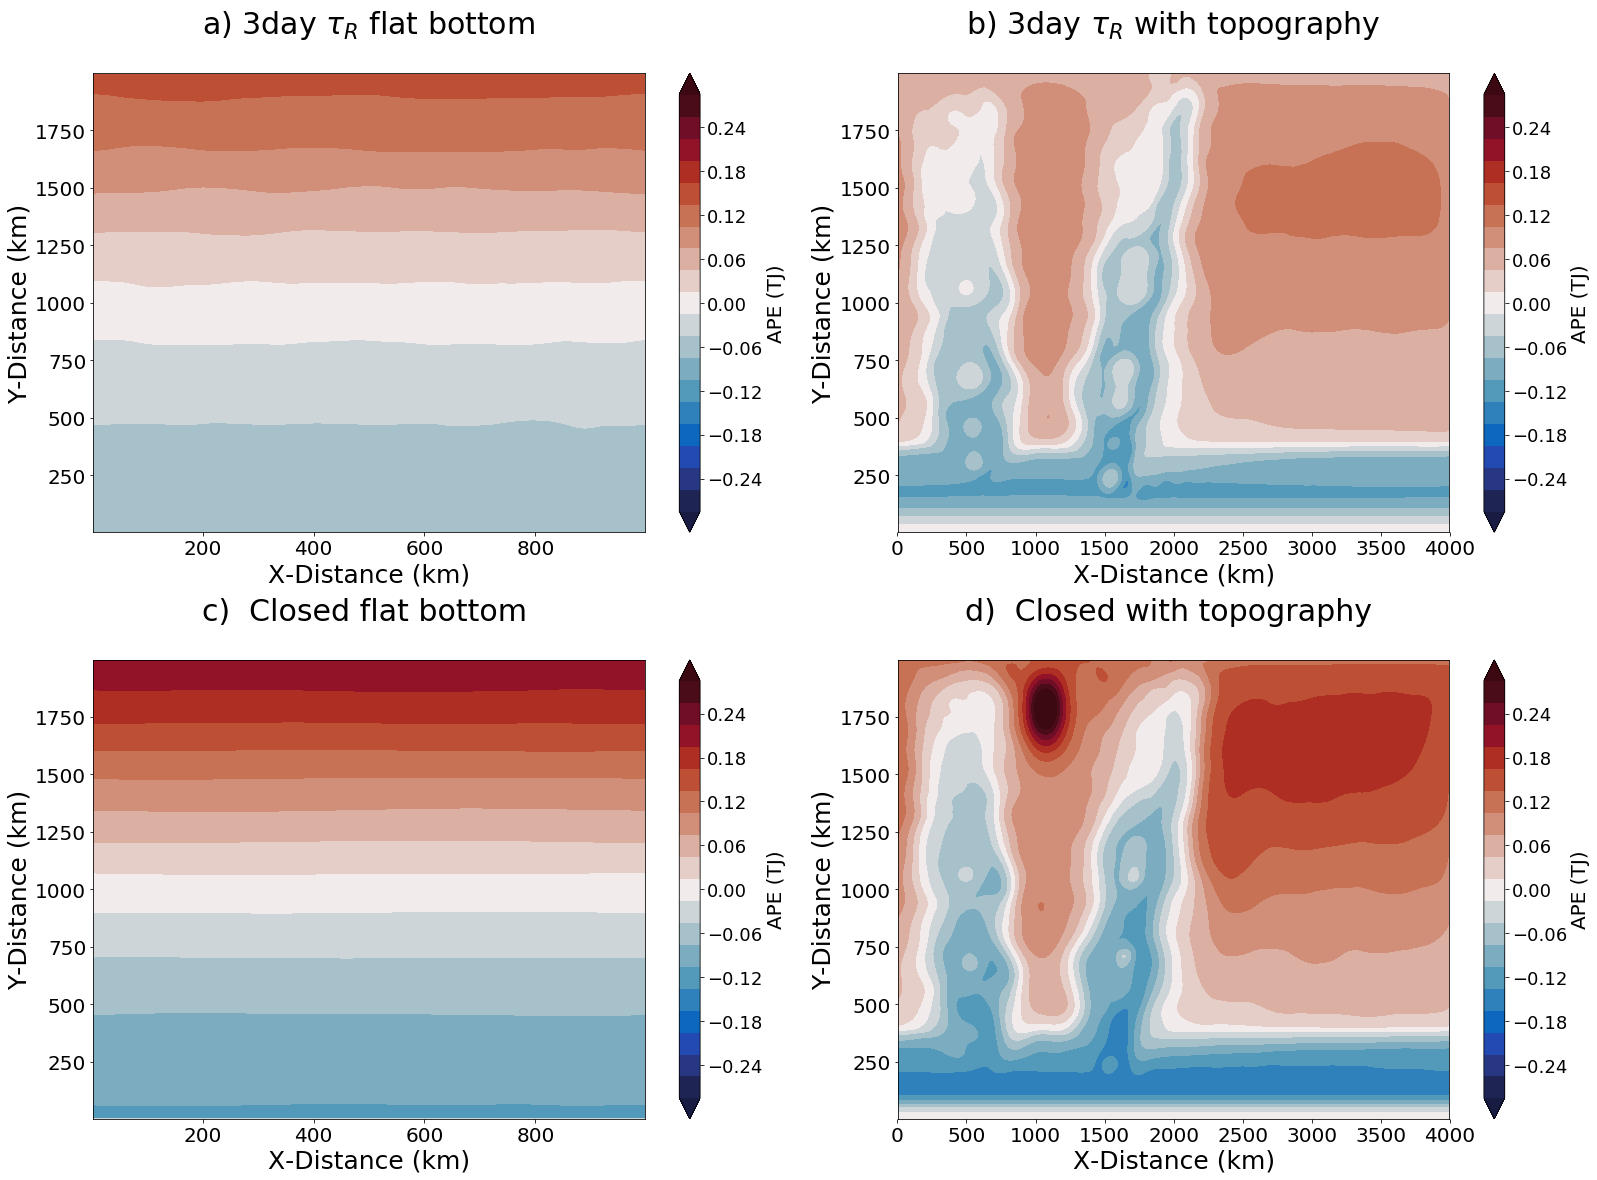

In [27]:
fig = plt.figure(figsize=(22.5, 16.5))
Psi_levs = (np.arange(-1., 1., .1)+0.05)
Psi_ticks =np.arange(-1., 1., .2)
Q_levs = np.arange(-0., 8., 1)
for i in range(len(Runs)):
   
    fname = x+str(Runs[i])
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    g = AC.APEcomputer(c)
    APE = g.calc_APE()
    scale = 0.3
    if i==1 or i==3:
        scale=0.3
    ax = fig.add_subplot(2, 2, i+1)
    p = ax.contourf(c.xc/1000, c.yc/1000,
                (APE)/10**12,Psi_levs*scale,cmap=cmocean.cm.balance, extend='both')
    print Figletter[i]+'max APE = '+str(round(sum((APE)/10**15),2))+' PJ'
    cbar = fig.colorbar(p, ax=ax,ticks=Psi_ticks*scale)
    cbar.ax.tick_params(labelsize=18)
    cbar.ax.set_ylabel(r'APE (TJ)', fontsize=20, )

    if str(Figletter[i])=='a) ':
        ax.set_title(str(Figletter[i])+r'3day $ \tau _{R} $ flat bottom' +'\n', fontsize=30)
    elif str(Figletter[i])=='b) ':
        ax.set_title(str(Figletter[i])+r'3day $ \tau _R $ with topography' +' \n', fontsize=30)
    elif str(Figletter[i])=='c) ':
        ax.set_title(str(Figletter[i])+r' Closed flat bottom ' +'\n', fontsize=30)
    elif str(Figletter[i])=='d) ':
        ax.set_title(str(Figletter[i])+r' Closed with topography ' +'\n', fontsize=30)
        

    ax.set_xlabel('X-Distance (km)', fontsize=25)
    ax.set_ylabel('Y-Distance (km)', fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()

## Eddy Heat Fluxes ##


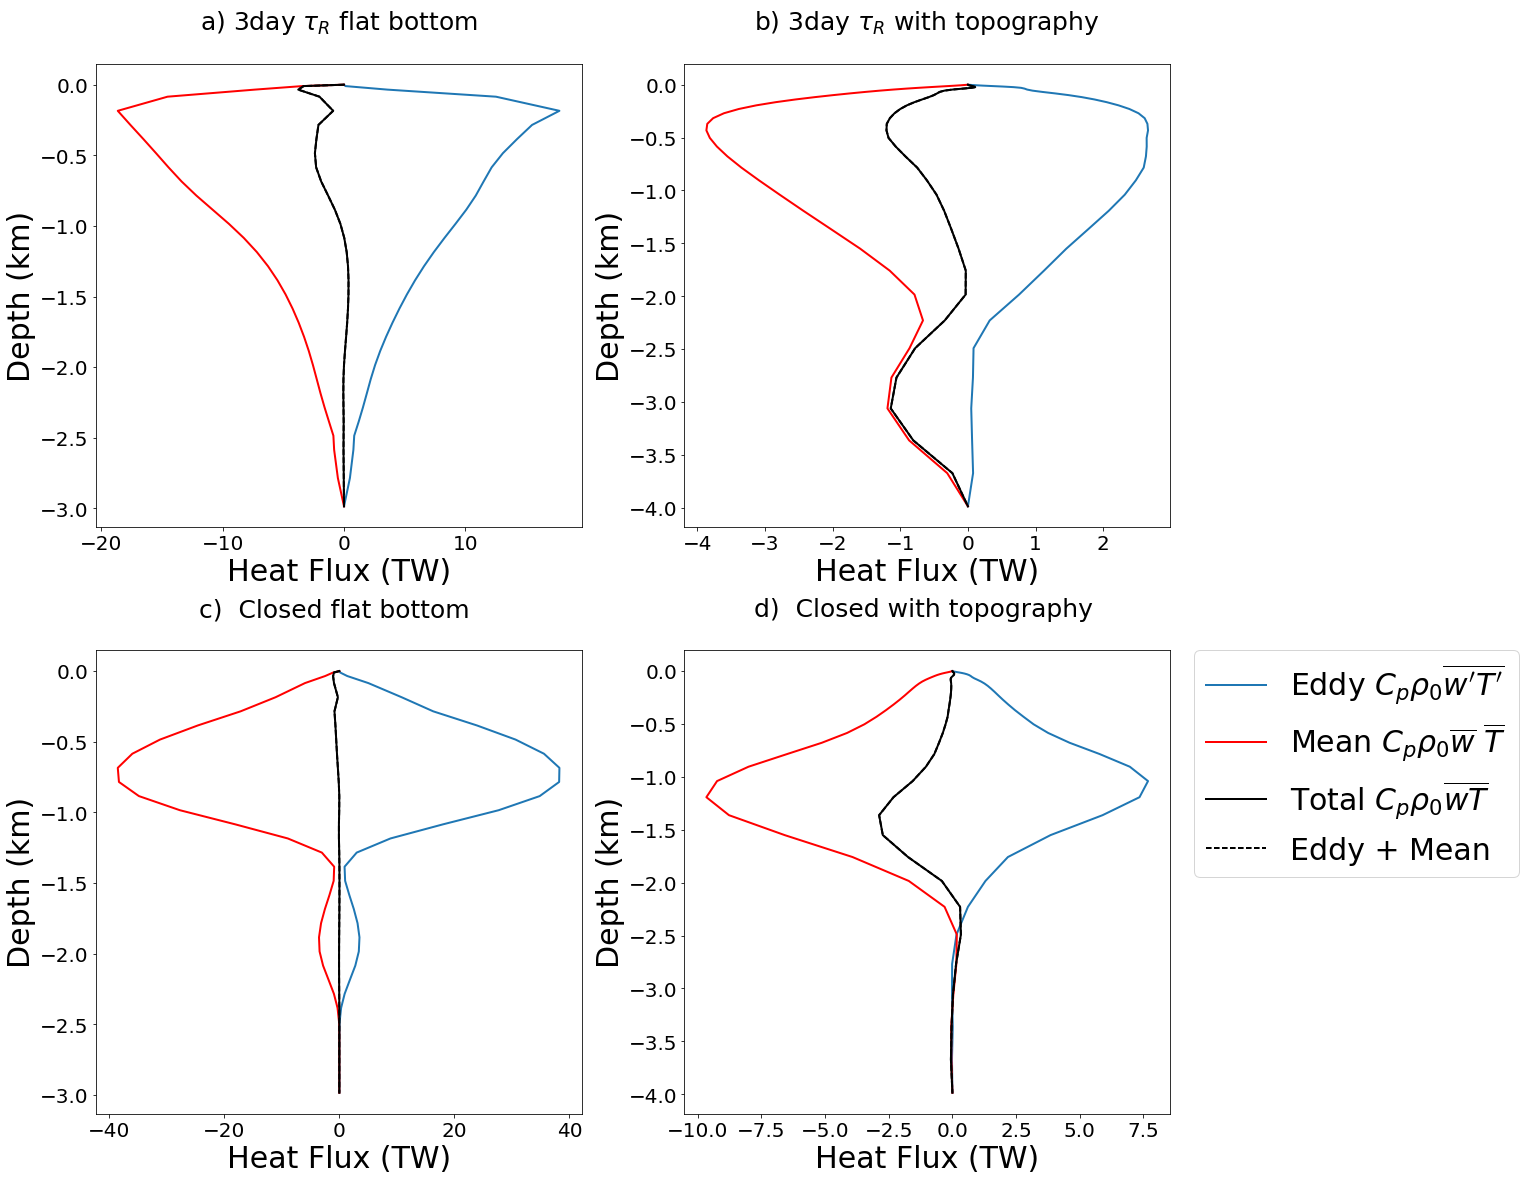

In [43]:
fig = plt.figure(figsize=(16.5, 16.5))
Q_levs = (arange(-.04,0.04,0.0021))
Q_ticks = np.arange(-.2, 0.2, .05)/10
for i in range(len(Runs)):
    fname = x+str(Runs[i])
    c = utils.ChannelSetup(output_dir=str(fname))
    RAC = c.rac[0,0]*np.ones((c.Ny+1,c.Nx))
    CellVolv = RAC*tile(c.dzf,(c.Nx,c.Ny+1,1)).T
    CellVolw = c.rac*tile(c.dzc,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar                                                   
    # put everything on the C Grid                                                         
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    if i==0 or i==2:
        W = (c.mnc('Tav_w.nc','WVEL'))
    else:
        W = (c.mnc('Tav.nc','WVEL'))
    npad = ((0, 1), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    VTbar = (V*Tv*CellVolv)
    WTbar = (W*Tw*CellVolw)
    VpTp = (VT*CellVolv - VTbar).mean(axis=2)
    WpTp = (WT*CellVolw - WTbar).mean(axis=2)
    VT = (VT*CellVolv).mean(axis=2)
    WT = (WT*CellVolw).mean(axis=2)
    VTbar = VTbar.mean(axis=2)
    WTbar = WTbar.mean(axis=2)
    MeanHF=1030*3985*(np.nansum(WTbar,axis=1))/10**12
    EddyHF=1030*3985*(np.nansum(WpTp,axis=1))/10**12
    TotalHF=1030*3985*(np.nansum(WT,axis=1))/10**12
    THF=MeanHF+EddyHF
    ax = fig.add_subplot(2, 2, i+1)
    E,=ax.plot(EddyHF,c.zf/1000,linewidth=2)
    M,=ax.plot(MeanHF,c.zf/1000,'r',linewidth=2)
    T,=ax.plot(TotalHF,c.zf/1000,'k',linewidth=2)
    MEp,=ax.plot(THF,c.zf/1000,'--k',linewidth=2)
    if str(Figletter[i])=='a) ':
        ax.set_title(str(Figletter[i])+r'3day $ \tau _{R} $ flat bottom' +'\n', fontsize=25)
    elif str(Figletter[i])=='b) ':
        ax.set_title(str(Figletter[i])+r'3day $ \tau _R $ with topography' +' \n', fontsize=25)
    elif str(Figletter[i])=='c) ':
        ax.set_title(str(Figletter[i])+r' Closed flat bottom ' +'\n', fontsize=25)
    elif str(Figletter[i])=='d) ':
        ax.set_title(str(Figletter[i])+r' Closed with topography ' +'\n', fontsize=25)
    ax.set_xlabel('Heat Flux (TW)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
lgd=legend([E,M,T,MEp],[r"Eddy $C_p \rho _0 \overline{w'T'}$",r"Mean $C_p \rho _0 \overline{w}\,\,\overline{T}$",
                    r"Total $C_p \rho _0 \overline{wT}$", "Eddy + Mean",],bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0.,  prop={'size': 30})


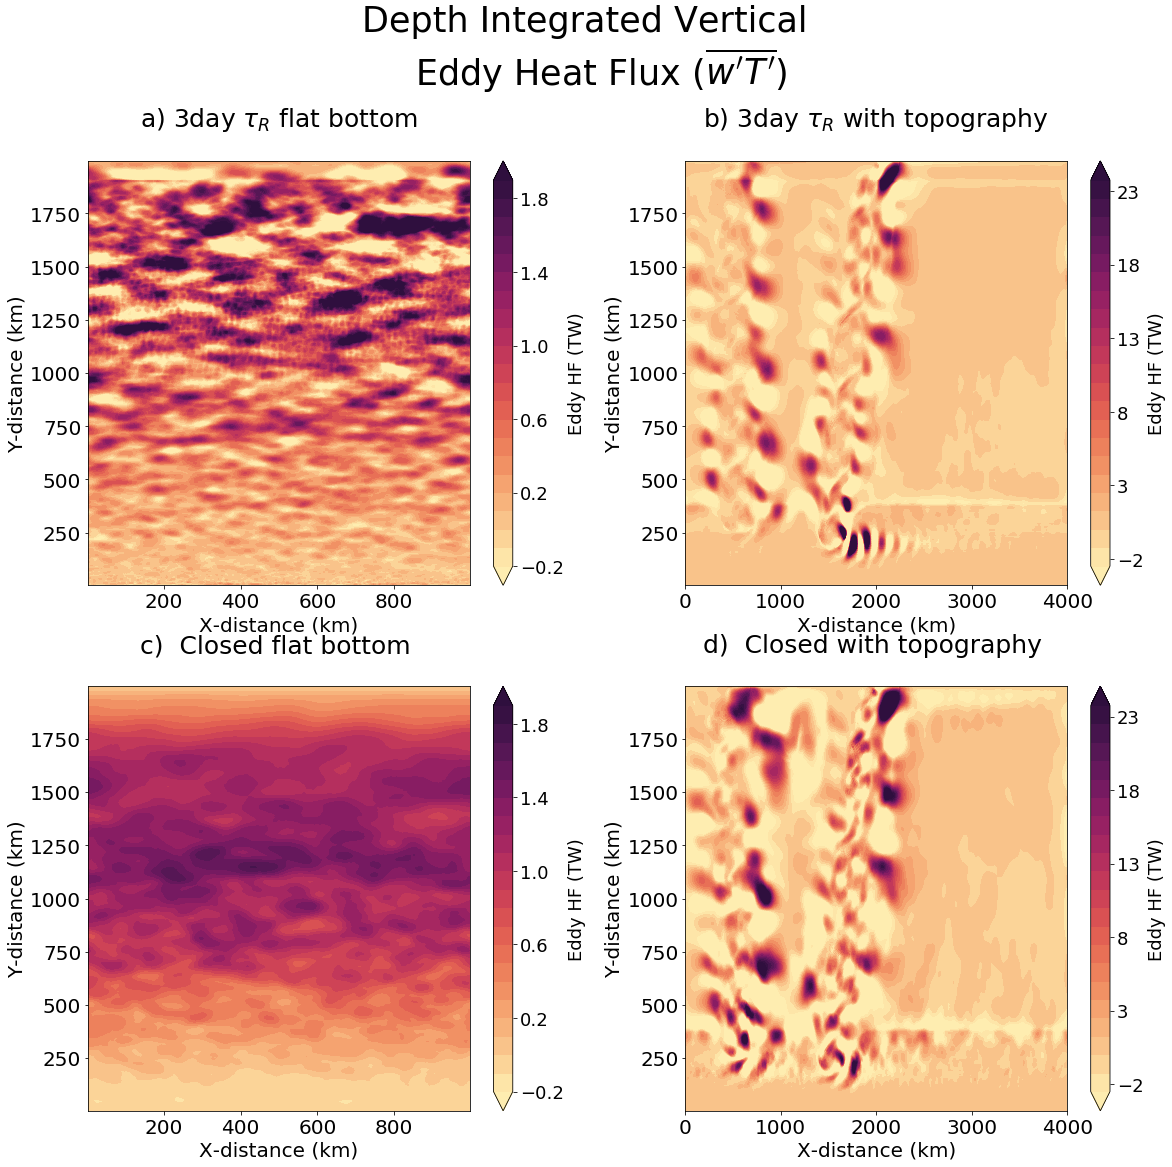

In [31]:
fig = plt.figure(figsize=(16.5, 16.5))
Q_levs = (arange(-.04,0.04,0.0021))
Q_ticks = np.arange(-.2, 0.2, .05)/10
for i in range(len(Runs)):
    #i =2 
    fname = x+str(Runs[i])
    c = utils.ChannelSetup(output_dir=str(fname))
    RAC = c.rac[0,0]*np.ones((c.Ny+1,c.Nx))
    CellVolv = RAC*tile(c.dzf,(c.Nx,c.Ny+1,1)).T
    CellVolw = c.rac*tile(c.dzc,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar                                                   
    # put everything on the C Grid                                                         
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    if i==0 or i==2:
        W = (c.mnc('Tav_w.nc','WVEL'))
    else:
        W = (c.mnc('Tav.nc','WVEL'))
    npad = ((0, 1), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    #Tw = np.pad(Tw, pad_width=npad, mode='constant', constant_values=0)
    VTbar = (V*Tv*CellVolv)
    WTbar = (W*Tw*CellVolw)
    VpTp = (VT*CellVolv - VTbar).sum(axis=0)
    WpTp = (WT*CellVolw - WTbar).sum(axis=0)
    VT = (VT*CellVolv).sum(axis=0)
    WT = (WT*CellVolw).sum(axis=0)
    VTbar = VTbar.mean(axis=2)
    WTbar = WTbar.mean(axis=2)
    scale = 0.2
    if i==1 or i==3:
        scale = 2.5
    MeanHF=1030*3985*WTbar/10**12
    EddyHF=1030*3985*WpTp/10**12
    TotalHF=1030*3985*WT/10**12
    ax = fig.add_subplot(2, 2, i+1)
    p = ax.contourf(c.xc/1000, c.yc/1000,
                EddyHF, (np.arange(-1,10,.5))*scale,cmap=cmocean.cm.matter, extend='both')
    cbar = fig.colorbar(p, ax=ax, ticks=np.round((np.arange(-1,10,2)+0.2)*scale,1))
    cbar.ax.tick_params(labelsize=18)
    cbar.ax.set_ylabel(r'Eddy HF (TW)', fontsize=18 )

    if str(Figletter[i])=='a) ':
        ax.set_title(str(Figletter[i])+r'3day $ \tau _{R} $ flat bottom' +'\n', fontsize=25)
    elif str(Figletter[i])=='b) ':
        ax.set_title(str(Figletter[i])+r'3day $ \tau _R $ with topography' +' \n', fontsize=25)
    elif str(Figletter[i])=='c) ':
        ax.set_title(str(Figletter[i])+r' Closed flat bottom ' +'\n', fontsize=25)
    elif str(Figletter[i])=='d) ':
        ax.set_title(str(Figletter[i])+r' Closed with topography ' +'\n', fontsize=25)
        
    ax.set_xlabel('X-distance (km)', fontsize=20)
    ax.set_ylabel('Y-distance (km)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
fig.suptitle('Depth Integrated Vertical \n '+' Eddy Heat Flux ($\overline{w^{\prime}T^{\prime}}$)',fontsize=35)
fig.subplots_adjust(top=0.85)

In [36]:
fname

'/noc/msm/scratch/students/hb1g13/Mobilis/3daynokpp/'

/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:45: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in less
/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:59: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:45: RuntimeWarning: divide by zero encountered in divide


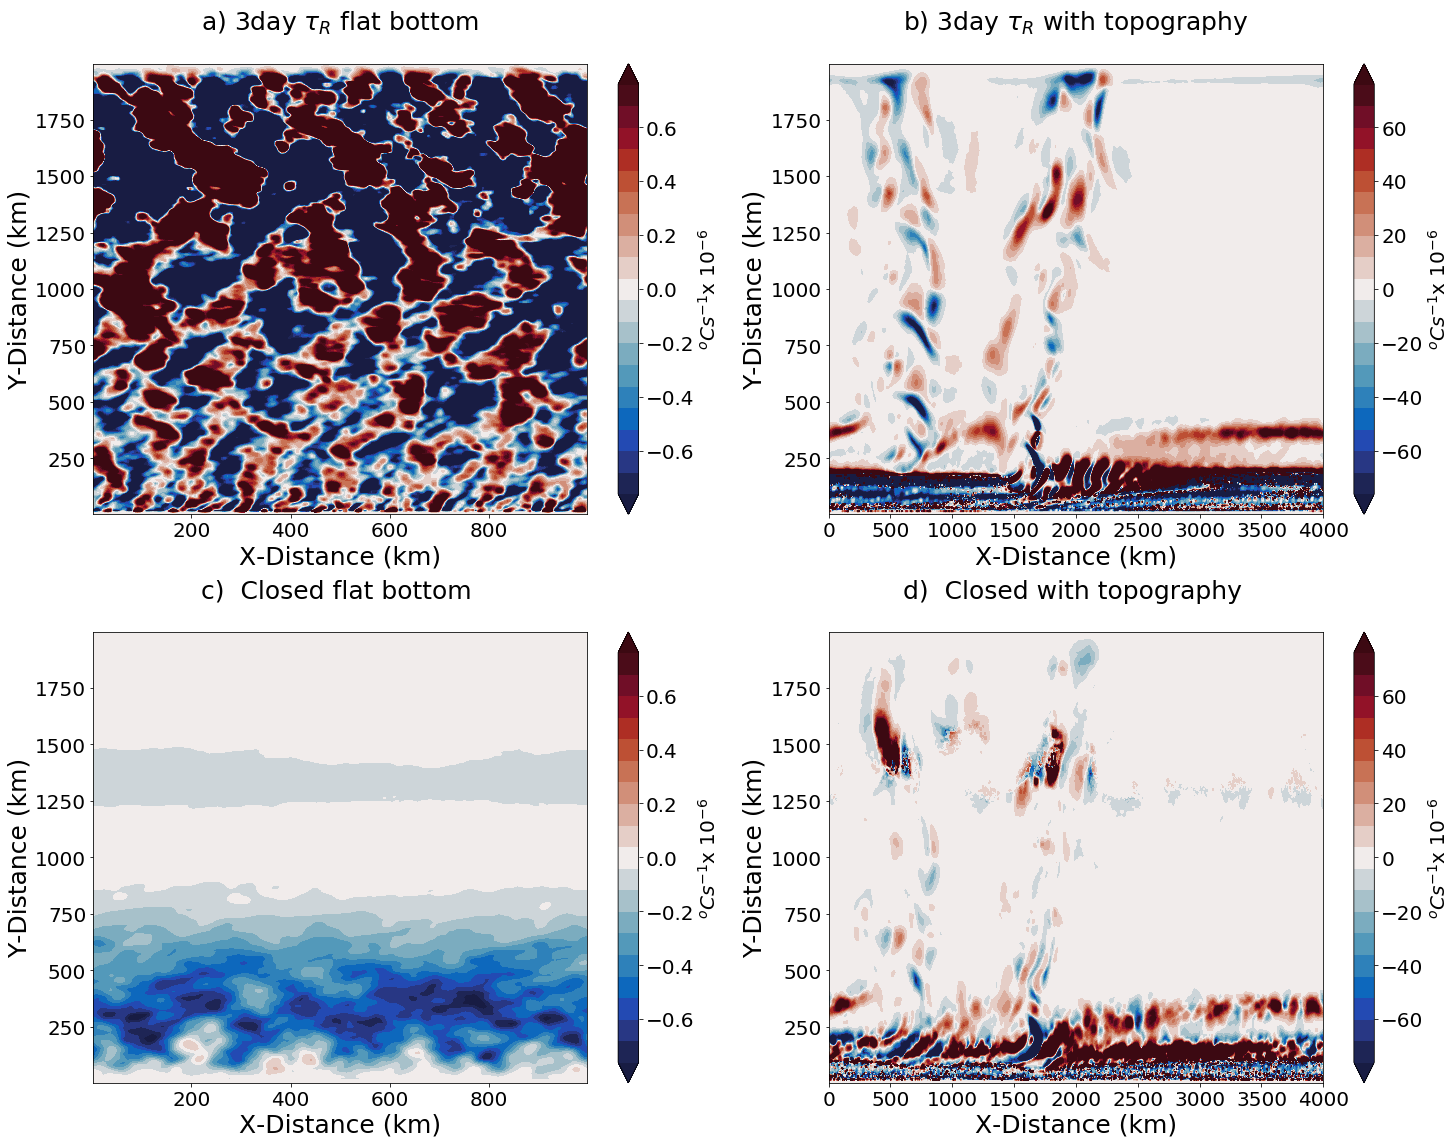

In [46]:
fig = plt.figure(figsize=(20.5, 16.))
Psi_levs = np.arange(-2.5, 2.5, .2)+0.05
Psi_ticks =np.arange(-2., 2., .5)
Q_levs = np.arange(-0., 8., 1)
for i in range(len(Runs)):
    #i =2 
    fname = x+str(Runs[i])
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNEL
    nopart = c. HFacC
    nopart[nopart<1] = 0
    ax = fig.add_subplot(2, 2, i+1)
    CellVol = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T*nopart
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar    
    # put everything on the C Grid                        
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    if i==0 or i==2:
        W = (c.mnc('Tav_w.nc','WVEL'))
    else:
        W = (c.mnc('Tav.nc','WVEL'))

    npad = ((0, 1), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    VTbar = V*Tv
    WTbar = W*Tw
    VpTp = VT - VTbar
    WpTp = WT - WTbar
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    dVTbar = (VTbar[:,0:-1,:] - VTbar[:,1::,:])*CellVol
    dWTbar = (WTbar[1::,:,:] - WTbar[0:-1,:,:])*CellVol
    dVTe = (VpTp[:,0:-1,:] - VpTp[:,1::,:])*CellVol
    dWTe = (WpTp[1::,:,:] - WpTp[0:-1,:,:])*CellVol
    Ty = (Tv[:,0:-1,:] - Tv[:,1::,:])*CellVol
    Tz = (Tw[1::,:,:] - Tw[0:-1,:,:])*CellVol
    Sp = zeros((c.Nz,c.Ny,c.Nx))
    Sp = -Ty/Tz
    Sp[abs(Sp)<10**-5]=10**-5
    Sp[isinf(Sp)]=10**-5
    Sp[isnan(Sp)]=10**-5
    Ade = ((c.vgrid_to_cgrid(VpTp)*Sp)[1::,:,:] 
           - (c.vgrid_to_cgrid(VpTp)*Sp)[0:-1,:,:])*CellVol[0:-1,:,:] 
    DE = ((c.wgrid_to_cgrid(WpTp)-(c.vgrid_to_cgrid(VpTp)*Sp))[1::,:,:] 
          - (c.wgrid_to_cgrid(WpTp)-(c.vgrid_to_cgrid(VpTp)*Sp))[0:-1,:,:])*CellVol[0:-1,:,:] 
    # Surface cor
    # Surf_corr_tend = (- WTHMASS(ix,iy)) / (DRF(1) * hFacC(ix,iy,1)
    Surcor = -(WTHMASS.mean(axis=0)).mean(axis=1)*c.dzf[0]
    npad = ((0, 1), (0, 0), (0, 0))
    DE = np.pad(DE, pad_width=npad, mode='constant', constant_values=0)
    ROC = -((np.nansum(Ade,axis=0) + dVTe.sum(axis=0) + dVTbar.sum(axis=0) + dWTbar.sum(axis=0)).sum(axis=1))/sum(CellVol.mean(axis=2))
    D = -np.sum((DE/(c.Depth*5000*5000) ),axis=0)
    # Tidy for boundary conditions
    ROC[0:3] = 0
    D[0:3] = 0
    if i==(len(Runs)):
        ROC = ROC*0.8
        D = D*0.8
    if i==0 or i==2:
        scale = .8
    else:
        scale = 80
    # Surface Heat Flux in W/m**2
    Q = c.mnc('SURF.nc', 'oceQnet').mean(axis=0).mean(axis=1)
    Psipred = -(Q)/(1000*3985)
    p = ax.contourf(c.xc/1000, c.yc/1000,
                D*10**4,(np.arange(-1,1,0.1)+0.05)*scale, cmap=cmocean.cm.balance, extend='both')
  
    cbar = fig.colorbar(p, ax=ax, ticks=np.arange(-1,1,0.25)*scale)
    cbar.ax.tick_params(labelsize=20)
    cbar.ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=20, )

    if str(Figletter[i])=='a) ':
        ax.set_title(str(Figletter[i])+r'3day $ \tau _{R} $ flat bottom' +'\n', fontsize=25)
    elif str(Figletter[i])=='b) ':
        ax.set_title(str(Figletter[i])+r'3day $ \tau _R $ with topography' +' \n', fontsize=25)
    elif str(Figletter[i])=='c) ':
        ax.set_title(str(Figletter[i])+r' Closed flat bottom ' +'\n', fontsize=25)
    elif str(Figletter[i])=='d) ':
        ax.set_title(str(Figletter[i])+r' Closed with topography ' +'\n', fontsize=25)
        
    ax.set_xlabel('X-Distance (km)', fontsize=25)
    ax.set_ylabel('Y-Distance (km)', fontsize=25)
    
    ax.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()


## EKE ##

a) max = 0.09, mean = 0.01
b) max = 0.07, mean = 0.03
c) max = 0.15, mean = 0.02
d) max = 0.14, mean = 0.05


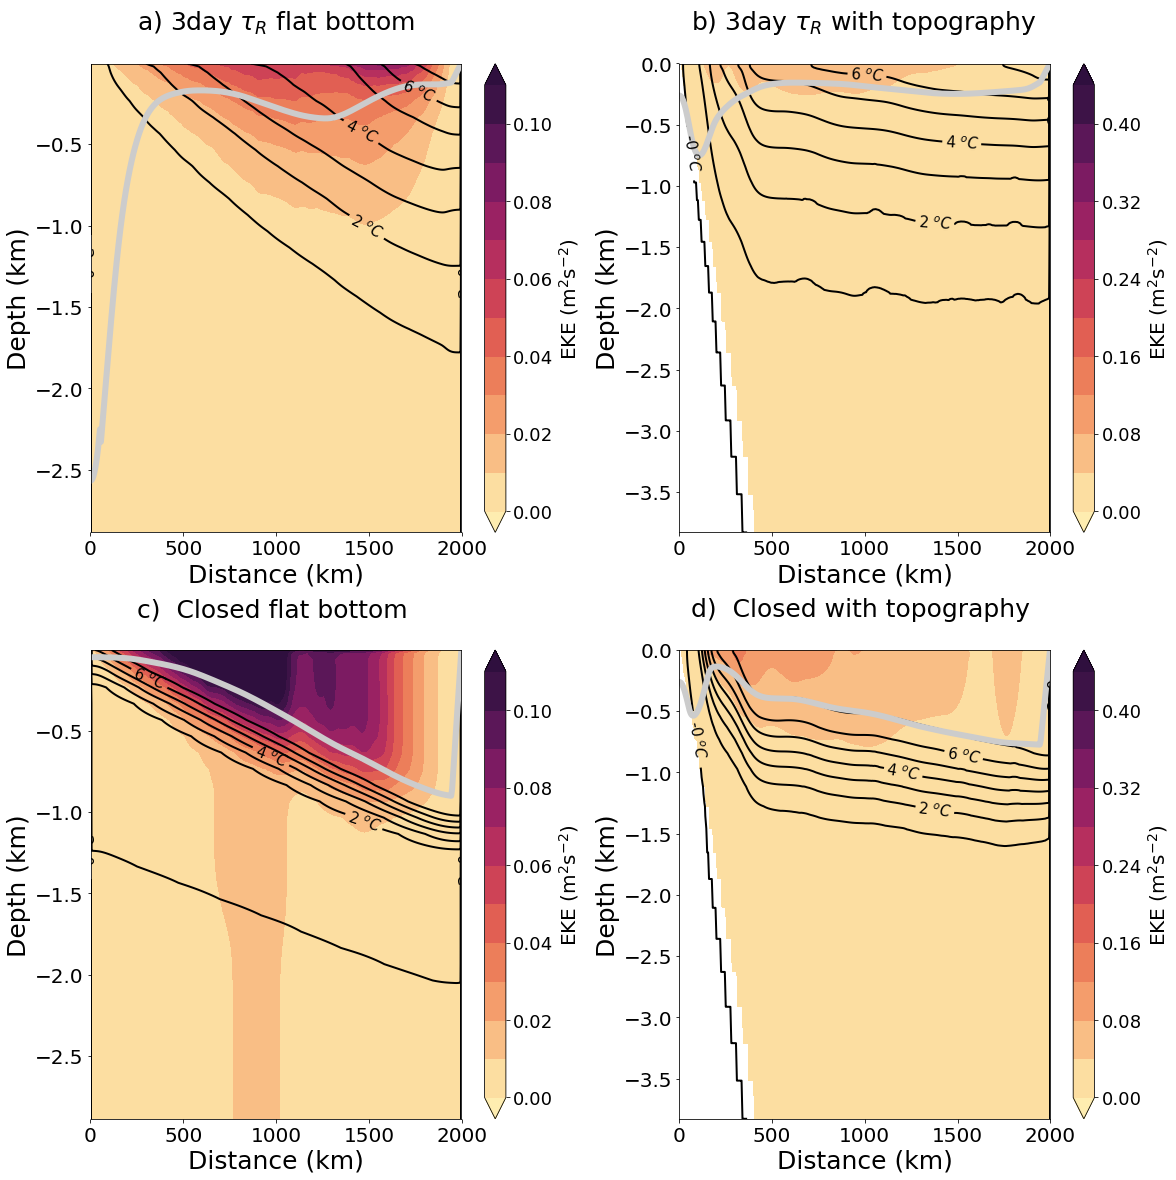

In [50]:
fig = plt.figure(figsize=(16.5, 16.5))
Psi_levs = np.arange(-0., .12, .010)
Psi_ticks = np.arange(-0., .12, .02)
Q_levs = np.arange(-0., 8., 1)
for i in range(len(Runs)):
    #i =2 
    fname = x+str(Runs[i])
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS

    EKE = c.calc_EKE() 
    print Figletter[i]+'max = '+str(round(np.max(EKE),2))+', mean = '+str(round(np.mean(EKE),2))
    npad = ((0, 1), (0, 0))
    Psi = np.pad(EKE, pad_width=npad, mode='constant', constant_values=0)
    scale = 1
 
    ax = fig.add_subplot(2, 2, i+1)
    scale= 1
    if i==1 or i==3:
        scale=4
    p = ax.contourf(c.yc/1000, c.zc/1000,
                EKE, Psi_levs*scale, cmap=cmocean.cm.matter, extend='both')
    q = ax.contour(c.yc/1000, c.zc/1000, c.get_zonal_avg('Tav.nc','THETA'), Q_levs, colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=15)
    mld = c.mnc('MLD.nc','MXLDEPTH')[0,:,:]
    # Diabatic layer area
    PI = c.mnc('PSI.nc',"LaPs1TH").mean(axis=2)
    PI = ma.masked_array(PI,PI<0.95)
    th = c.mnc('PSI.nc',"LaHs1TH").mean(axis=2)
    depths = np.cumsum(th[::-1],axis=0)[::-1]
    
    # Find Max ROC and depth of diabatic layer
    mld = c.mnc('MLD.nc','MXLDEPTH')[0,:,:].mean(axis=1)
    DDL = np.zeros(len(c.yc))
    DDL_matrix = np.zeros_like(Psi)
    psi = c.get_psi_iso()
    for jj in range(len(c.yc)):
        if (ma.all(PI[:, jj] == 1) or np.all(psi[:, jj] == -0) or PI[:, jj].mask.all()):
            continue
        indx = ma.nonzero(PI[:, jj] < 1)[0]
        b = indx
        if len(b) >= 2 and (b[1]-b[0]) > 1:
            a = b[1]
        else:
            a = b[0]
        if a < 41 and depths[a-1, jj] - depths[a, jj] > 150:
            a = a - 1
        DDL[jj] = depths[a, jj]
    r = ax.plot(c.yc/1000, SG.savitzky_golay(-mld/1000, 21, 1), scalex=False,
                scaley=False, color='0.8', linestyle='-', linewidth=6)
   
    
    cbar = fig.colorbar(p, ax=ax,ticks=Psi_ticks*scale)
    cbar.ax.tick_params(labelsize=18)
    cbar.ax.set_ylabel(r'EKE (m$^2$s$^{-2}$)', fontsize=20, )
    if str(Figletter[i])=='a) ':
        ax.set_title(str(Figletter[i])+r'3day $ \tau _{R} $ flat bottom' +'\n', fontsize=25)
    elif str(Figletter[i])=='b) ':
        ax.set_title(str(Figletter[i])+r'3day $ \tau _R $ with topography' +' \n', fontsize=25)
    elif str(Figletter[i])=='c) ':
        ax.set_title(str(Figletter[i])+r' Closed flat bottom ' +'\n', fontsize=25)
    elif str(Figletter[i])=='d) ':
        ax.set_title(str(Figletter[i])+r' Closed with topography ' +'\n', fontsize=25)
        

    ax.set_xlabel('Distance (km)', fontsize=25)
    ax.set_ylabel('Depth (km)', fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()


max = 0.0148275804147
mean = 0.00780537416323
max = 0.066801219618
mean = 0.017623501842
max = 0.0363571393676
mean = 0.017408205024
max = 0.295893734137
mean = 0.0247463242035


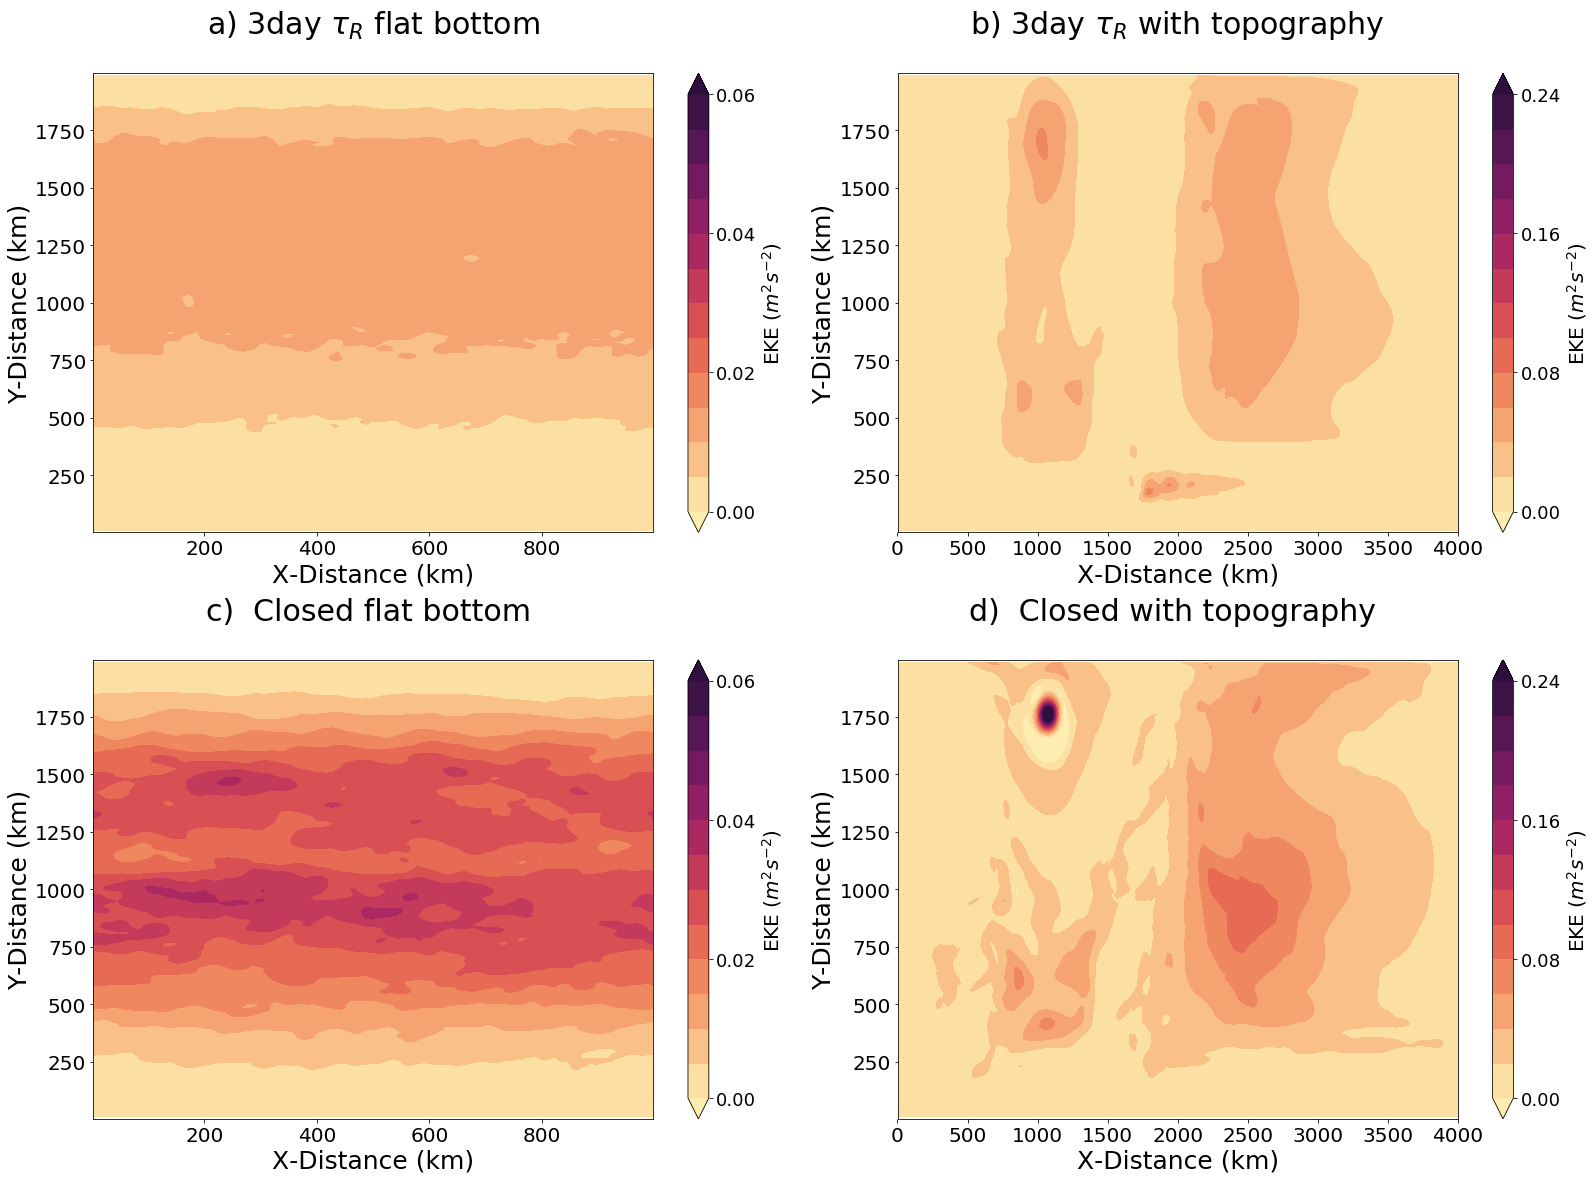

In [51]:
fig = plt.figure(figsize=(22.5, 16.5))
Psi_levs = np.arange(-0., .065, .005)
Psi_ticks = np.arange(-0., .08, .02)
Q_levs = np.arange(-0., 8., 1)
for i in range(len(Runs)):
    #i =2 
    fname = x+str(Runs[i])
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS

    EKE = c.calc_EKE_all()*np.tile(c.dzf,(c.Nx,c.Ny,1)).T
    
    EKE = np.sum(EKE,axis=0)/(3000)
    print 'max = '+str(np.max(EKE))
    print 'mean = '+str(np.mean(EKE))
    npad = ((0, 1), (0, 0))
    Psi = np.pad(EKE, pad_width=npad, mode='constant', constant_values=0)
    scale = 1
    if i==1 or i==3:
        scale=4
    ax = fig.add_subplot(2, 2, i+1)
    p = ax.contourf(c.xc/1000, c.yc/1000,
                EKE, Psi_levs*scale, cmap=cmocean.cm.matter, extend='both')
    cbar = fig.colorbar(p, ax=ax,ticks=Psi_ticks*scale)
    cbar.ax.tick_params(labelsize=18)
    cbar.ax.set_ylabel(r'EKE ($m^2s^{-2}$)', fontsize=20, )
    if str(Figletter[i])=='a) ':
        ax.set_title(str(Figletter[i])+r'3day $ \tau _{R} $ flat bottom' +'\n', fontsize=30)
    elif str(Figletter[i])=='b) ':
        ax.set_title(str(Figletter[i])+r'3day $ \tau _R $ with topography' +' \n', fontsize=30)
    elif str(Figletter[i])=='c) ':
        ax.set_title(str(Figletter[i])+r' Closed flat bottom ' +'\n', fontsize=30)
    elif str(Figletter[i])=='d) ':
        ax.set_title(str(Figletter[i])+r' Closed with topography ' +'\n', fontsize=30)
        

    ax.set_xlabel('X-Distance (km)', fontsize=25)
    ax.set_ylabel('Y-Distance (km)', fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()


## ACC ##
### U VEL ###

In [53]:
# Path root
x = '/noc/msm/scratch/students/hb1g13/Mobilis'
# Now Make file structure
tau = ['/Part2/L90_3day/','/3daynokpp/','/Part2/L90_tref_closed/','/Closeddaynokpp/']
Runs=np.array(tau)
Figletter = ['a) ','b) ','c) ','d) ','e) ','f) ','g) ','h) ','j) ']

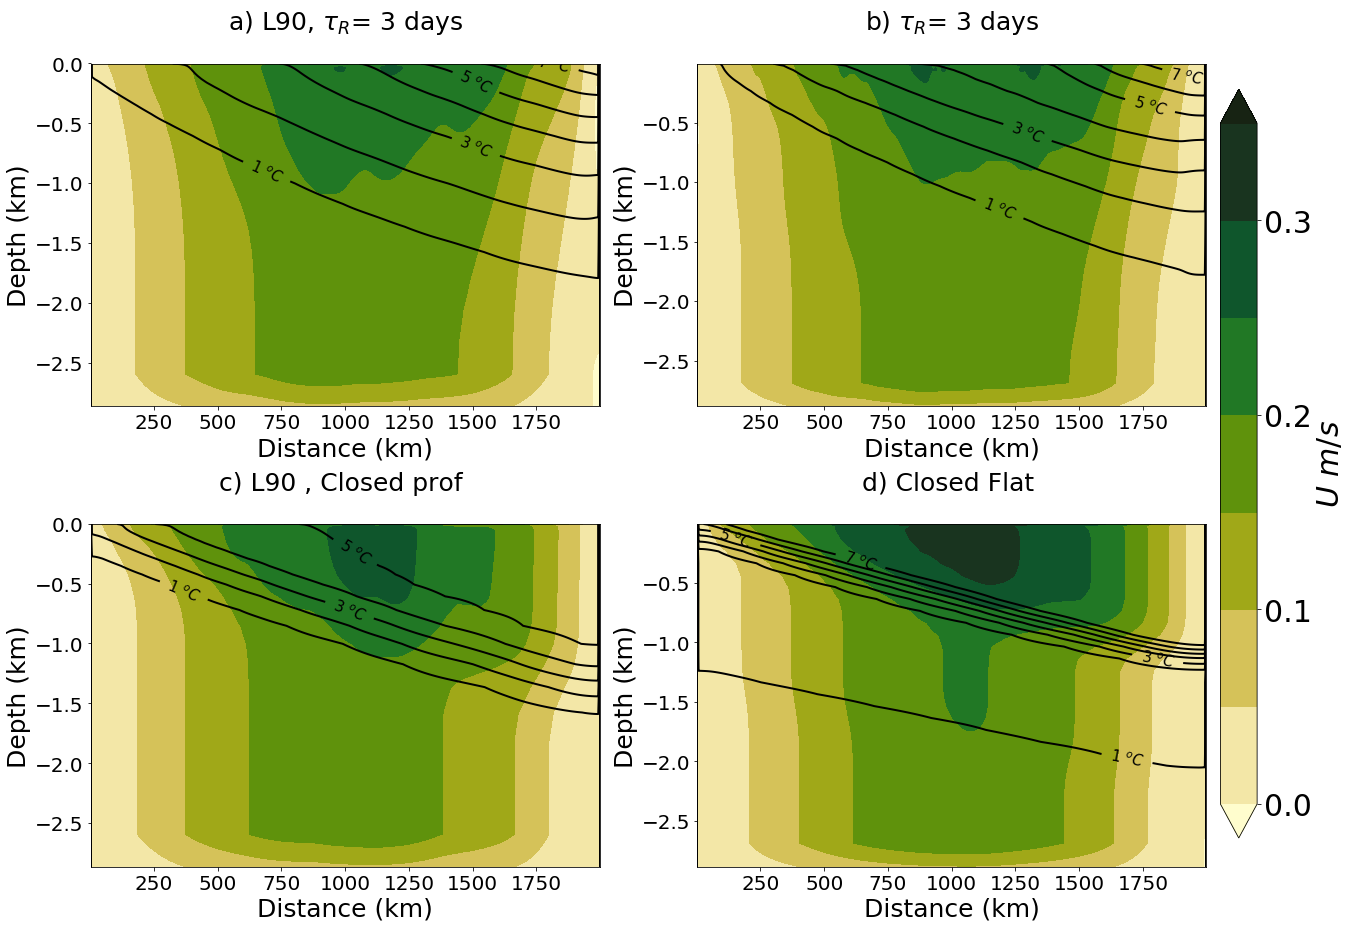

In [59]:
fig = plt.figure(figsize=(17.0, 13.))
# Create Panels

Psi_levs = np.arange(0., 0.4, .05)
Psi_ticks =np.arange(0., 5., .1)
Eddy_ticks = (np.arange(-3, 1, .5))
E_levs = np.arange(-3., 1, .25)
Q_levs = arange(-1,8,1)

for i in range(len(Runs)):
    ax = fig.add_subplot(2, 2, i+1)
    fname = x+str(Runs[i])
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    Ubar = ma.mean(c.mnc('Tav.nc','UVEL',mask=c.HFacW),axis=2)
    Ubar[-1,:] =  Ubar[-2,:]/2
    
    Depthav =  c.depth_average(c.ugrid_to_cgrid(c.mnc('Tav.nc','UVEL')))
    BarotropicU = tile(Depthav,(c.Nz,1,1))
    U = c.mnc('Tav.nc','UVEL')
    baroclinic = (c.ugrid_to_cgrid(U*c.HFacW)-BarotropicU)
    #Ubar[lmsk==0] = np.nan
    
    Q2_levs = (np.arange(-1,8,1))

    p = ax.contourf(c.yc/1000, c.zc/1000,
               Ubar, Psi_levs, cmap=cmocean.cm.speed, extend='both')
    q = ax.contour(c.yc/1000, c.zc/1000, c.get_zonal_avg('Tav.nc','THETA'), Q_levs, colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=15)
    if str(Figletter[i])=='a) ':
        ax.set_title(str(Figletter[i])+r'L90, $\tau _R $= 3 days'+'\n', fontsize=25)
    elif str(Figletter[i])=='b) ':
        ax.set_title(str(Figletter[i])+r'$\tau _R $= 3 days'+ '\n', fontsize=25)
    elif str(Figletter[i])=='c) ':
        ax.set_title(str(Figletter[i])+'L90 , Closed prof \n', fontsize=25)
    elif str(Figletter[i])=='d) ':
        ax.set_title(str(Figletter[i])+'Closed Flat \n', fontsize=25)

    ax.set_xlabel('Distance (km)', fontsize=25)
    ax.set_ylabel('Depth (km)', fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax, ticks=Psi_ticks)
cbar.ax.set_ylabel(r'$U \,\, m/s$', fontsize=30, )
cbar.ax.tick_params(labelsize=30)

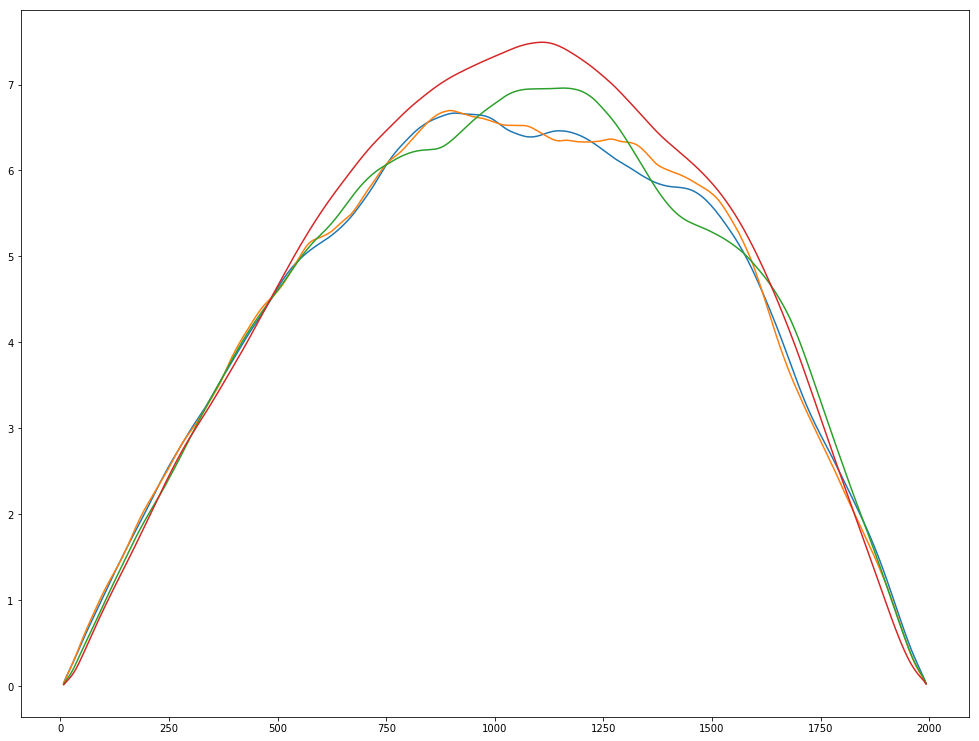

In [63]:
fig = plt.figure(figsize=(17.0, 13.))
# Create Panels

Psi_levs = np.arange(0., 8, .4)
Psi_ticks =np.arange(0., 10, 2.5)
Eddy_ticks = (np.arange(-3, 1, .5))
E_levs = np.arange(-3., 1, .25)
Q_levs = arange(-1,8,1)

for i in range(len(Runs)):
    
    fname = x+str(Runs[i])
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    Ubar = ma.mean(c.mnc('Tav.nc','UVEL',mask=c.HFacW),axis=2)
    if i==0 or i==3:
        Ubar[-1,:] =Ubar[-2,:]
    if i==2  or i==5:
        Ubar = ma.mean(c.mnc('Tav.nc','UVEL',mask=c.HFacW)[:,:,-400:-1],axis=2)

    Depthav =  c.depth_average(c.ugrid_to_cgrid(c.mnc('Tav.nc','UVEL')))
    BarotropicU = Depthav
    


    p = plt.plot(c.yc/1000, BarotropicU.mean(axis=1)*10**3)
   

    
    ax.set_xlabel('Distance (km)', fontsize=25)
    ax.set_ylabel('Depth (km)', fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=20)